# **Figure 7.** Gas Turbulence
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created | 04/20/2022          |
| Updated | 11/15/2022          |

AB/0.05
	Ma_x = 1.1e-02 ± 3e-04
	Ma_z = 7.6e-03 ± 3e-04

	δu_xδu_y = -8.6e-04
	δu_x = 1.6e-02
	δu_y = -3.8e-03
	δu_y*δu_x = -6.1e-05
BA/0.05
	Ma_x = 1.0e-02 ± 1e-03


/home/stanley/bitbucket/ccyang/athena-dust/vis/python/athena_read.py:66: AthenaWarning: Multiple headers found; using most recent data
  warnings.warn('Multiple headers found; using most recent data', AthenaWarning)


	Ma_z = 3.9e-02 ± 1e-03

	δu_xδu_y = 1.1e-03
	δu_x = -1.6e-02
	δu_y = -7.4e-03
	δu_y*δu_x = 1.1e-04


,Case,a,±σ_a,k,±σ_k
0,AB,-5.57e-03,(7e-04),1.85,(3e-02)
1,BA,4.73e-03,(8e-04),1.82,(4e-02)


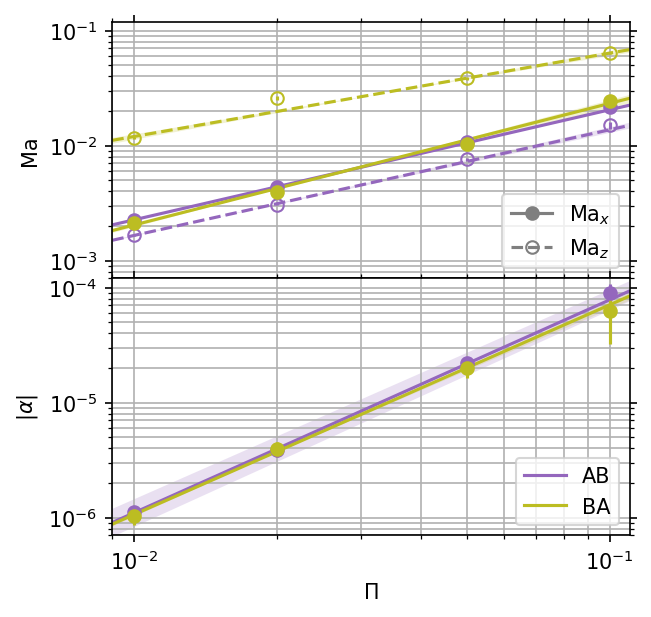

In [4]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4.45, 4.45), dpi=150)
workdir = '../unstrat'
cases = [['AB', 'tab:purple',  5], # [case, line style, t_sat]
         ['BA', 'tab:olive', 150]]
Pis = [0.01, 0.02, 0.05, 0.1]
res = '2048'
dirs = [['x', 'dux',   'dux2', 1, 'solid',  'full'],
        ['z', '2-mom', '2-KE', 2, 'dashed', 'none']]
avgMas = np.zeros((len(Pis), len(dirs)))
stdMas = np.zeros((len(Pis), len(dirs)))
avg_alpha_xys = np.zeros(len(Pis))
std_alpha_xys = np.zeros(len(Pis))
pow_law = lambda x, a, k : a*x**k
xs = np.linspace(9e-3, 1.1e-1)
Ma_runs, tdirs = [], []
Ma_as, Ma_a_errs = [], []
Ma_ks, Ma_k_errs = [], []
alpha_cases = []
alpha_as, alpha_a_errs = [], []
alpha_ks, alpha_k_errs = [], []

for i, case in enumerate(cases):
    print(f'{case[0]:s}/0.05')
    for j, dir in enumerate(dirs):
        for k, Pi in enumerate(Pis):
            path = f'{workdir}/{case[0]}/{Pi:0.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            hst = athena_read.hst(f'{path}/output/SI.hst')
            c_s = athinput['hydro']['iso_sound_speed']
            i_sat = int(case[2]/athinput['output3']['dt'])
            Mg = hst['mass']

            # Compute turbulent Mach numbers
            dispersions = np.sqrt(dir[3]*hst[dir[2]]/Mg - (hst[dir[1]]/Mg)**2)
            Mas = dispersions/c_s
            avgMas[k, j] = np.average(Mas[i_sat:])
            stdMas[k, j] = np.std(Mas[i_sat:])
            if Pi == 0.05:
                print(f'\tMa_{dir[0]} = {avgMas[k, j]:.1e} ± {stdMas[k, j]:.0e}')

            # Compute Reynolds stress and turbulent alpha
            if dir[0] == 'z':
                dux = hst['dux']/Mg
                duy = hst['duy']/Mg
                duxduy = hst['duxduy']/Mg
                if Pi == 0.05: # Diagnostics
                    print(f'\n\tδu_xδu_y = {duxduy[i_sat]:.1e}')
                    print(f'\tδu_x = {dux[i_sat]:.1e}')
                    print(f'\tδu_y = {duy[i_sat]:.1e}')
                    print(f'\tδu_y*δu_x = {duy[i_sat]*dux[i_sat]:.1e}')
                Wxy = (duxduy - duy*dux)
                avg_alpha_xys[k] = np.average(Wxy[i_sat:])/c_s**2
                std_alpha_xys[k] = np.std(Wxy[i_sat:])/c_s**2

        # Fit and plot turbulent Mach numbers
        popt, pcov = curve_fit(pow_law, Pis, avgMas[:, j], sigma=stdMas[:, j])
        perr = np.sqrt(np.diag(pcov))
        a, a_err, k, k_err = popt[0], perr[0], popt[1], perr[1]
        fit_low = pow_law(xs, a - a_err, k - k_err)
        fit_high = pow_law(xs, a + a_err, k + k_err)
        axs[0].errorbar(Pis, avgMas[:, j], stdMas[:, j], fmt='o',
                        color=case[1], fillstyle=dir[5])
        axs[0].plot(xs, pow_law(xs, *popt), ls=dir[4], color=case[1])
        axs[0].fill_between(xs, fit_low, fit_high, color=case[1], ec=None,
                        alpha=0.2)
        Ma_runs.append(case[0]); tdirs.append(dir[0])
        Ma_as.append(a); Ma_a_errs.append(a_err)
        Ma_ks.append(k); Ma_k_errs.append(k_err)

    # Fit and plot turbulent alpha
    popt, pcov = curve_fit(pow_law, Pis, avg_alpha_xys,
                           sigma=std_alpha_xys)
    perr = np.sqrt(np.diag(pcov))
    a, a_err, k, k_err = popt[0], perr[0], popt[1], perr[1]
    fit_low = pow_law(xs, a - a_err, k - k_err)
    fit_high = pow_law(xs, a + a_err, k + k_err)
    axs[1].errorbar(Pis, np.abs(avg_alpha_xys), std_alpha_xys, fmt='o',
                    color=case[1])
    axs[1].plot(xs, np.abs(pow_law(xs, *popt)), color=case[1])
    axs[1].fill_between(xs, np.abs(fit_low), np.abs(fit_high), color=case[1],
                        ec=None, alpha=0.2)
    alpha_cases.append(case[0])
    alpha_as.append(a); alpha_a_errs.append(a_err)
    alpha_ks.append(k); alpha_k_errs.append(k_err)

# Plot line style ghost points; format plots and legend
axs[0].plot([], [], color='tab:gray', label='Ma$_x$', marker='o')
axs[0].plot([], [], color='tab:gray', ls='--', label='Ma$_z$', marker='o',
            fillstyle='none')
axs[0].set(ylabel='Ma', ylim=(7e-4, 1.2e-1), yscale='log')
axs[1].plot([], [], color='tab:purple', label='AB')
axs[1].plot([], [], color='tab:olive', label='BA')
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$|\alpha|$', xlim=(9e-3, 1.1e-1),
           ylim=(7e-7, 1.2e-4))

for ax in axs.flat:
    ax.grid(which='both')
    ax.legend(loc='lower right')
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(which='both', top=True, right=True)

plt.subplots_adjust(hspace=0)
plt.savefig('figs/machs.pdf', bbox_inches='tight', pad_inches=0.01)

df1 = pd.DataFrame({
    'Case' : Ma_runs,
    'Dir'  : tdirs,
    'a'    : Ma_as,
    '±σ_a' : Ma_a_errs,
    'k'    : Ma_ks,
    '±σ_k' : Ma_k_errs,})
s1 = df1.style.format({
    'a'    : '{:.3f}',
    '±σ_a' : '({:.0e})',
    'k'    : '{:.2f}',
    '±σ_k' : '({:.0e})',})

df2 = pd.DataFrame({
    'Case' : alpha_cases,
    'a'    : alpha_as,
    '±σ_a' : alpha_a_errs,
    'k'    : alpha_ks,
    '±σ_k' : alpha_k_errs,})
s2 = df2.style.format({
    'a'    : '{:.2e}',
    '±σ_a' : '({:.0e})',
    'k'    : '{:.2f}',
    '±σ_k' : '({:.0e})',})
# s1
s2

### $\alpha$ in symmetric log scale

AB/0.05
	Ma_x = 1.1e-02 ± 3e-04
	Ma_z = 7.6e-03 ± 3e-04

	δu_xδu_y = -8.6e-04
	δu_x = 1.6e-02
	δu_y = -3.8e-03
	δu_y*δu_x = -6.1e-05
BA/0.05


/home/stanley/bitbucket/ccyang/athena-dust/vis/python/athena_read.py:66: AthenaWarning: Multiple headers found; using most recent data
  warnings.warn('Multiple headers found; using most recent data', AthenaWarning)


	Ma_x = 1.0e-02 ± 1e-03
	Ma_z = 3.9e-02 ± 1e-03

	δu_xδu_y = 1.1e-03
	δu_x = -1.6e-02
	δu_y = -7.4e-03
	δu_y*δu_x = 1.1e-04


,Case,a,±σ_a,k,±σ_k
0,AB,-5.57e-03,(7e-04),1.85e+00,(3e-02)
1,BA,4.73e-03,(8e-04),1.82e+00,(4e-02)


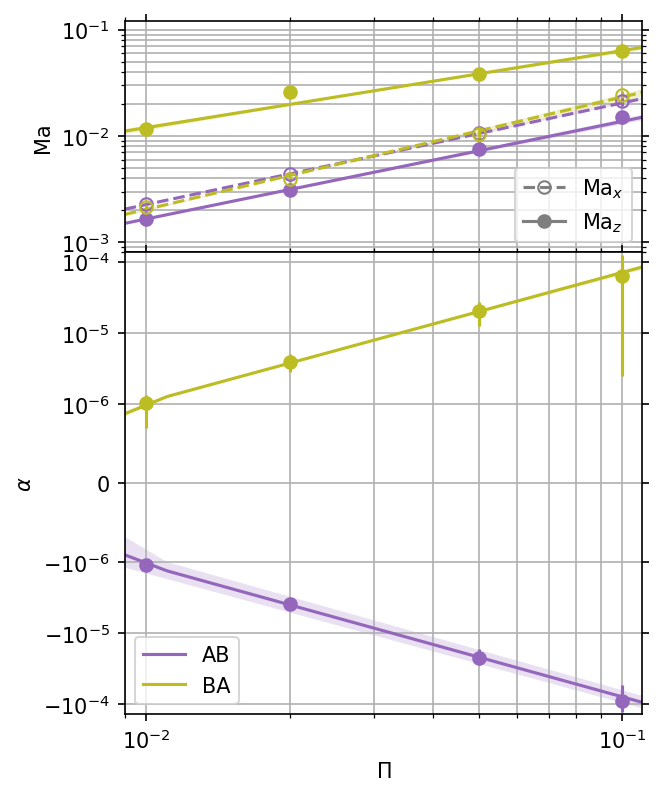

In [45]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[1,2],
                        figsize=(4.45, 11), dpi=150)
workdir = '../unstrat'
cases = [['AB', 'tab:purple',  5], # [case, line style, t_sat]
         ['BA', 'tab:olive', 150]]
Pis = [0.01, 0.02, 0.05, 0.1]
res = '2048'
dirs = [['x', 'dux',   'dux2', 1, 'dashed', 'none'],
        ['z', '2-mom', '2-KE', 2, 'solid' , 'full']]
avgMas = np.zeros((len(Pis), len(dirs)))
stdMas = np.zeros((len(Pis), len(dirs)))
avg_alpha_xys = np.zeros(len(Pis))
std_alpha_xys = np.zeros(len(Pis))
pow_law = lambda x, a, k : a*x**k
xs = np.linspace(9e-3, 1.1e-1)
Ma_runs, tdirs = [], []
Ma_as, Ma_a_errs = [], []
Ma_ks, Ma_k_errs = [], []
Alpha_cases = []
Alpha_as, Alpha_a_errs = [], []
Alpha_ks, Alpha_k_errs = [], []

for i, case in enumerate(cases):
    print(f'{case[0]:s}/0.05')
    for j, dir in enumerate(dirs):
        for k, Pi in enumerate(Pis):
            path = f'{workdir}/{case[0]}/{Pi:0.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            hst = athena_read.hst(f'{path}/output/SI.hst')
            c_s = athinput['hydro']['iso_sound_speed']
            i_sat = int(case[2]/athinput['output3']['dt'])
            Mg = hst['mass']

            # Compute turbulent Mach numbers
            dispersions = np.sqrt(dir[3]*hst[dir[2]]/Mg - (hst[dir[1]]/Mg)**2)
            Mas = dispersions/c_s
            avgMas[k, j] = np.average(Mas[i_sat:])
            # CALC STD IN LOG SPACE
            stdMas[k, j] = np.std(Mas[i_sat:])
            if Pi == 0.05:
                print(f'\tMa_{dir[0]} = {avgMas[k, j]:.1e} ± {stdMas[k, j]:.0e}')

            # Compute Reynolds stress and turbulent alpha
            if dir[0] == 'z':
                dux = hst['dux']/Mg
                duy = hst['duy']/Mg
                duxduy = hst['duxduy']/Mg
                if Pi == 0.05: # Diagnostics
                    print(f'\n\tδu_xδu_y = {duxduy[i_sat]:.1e}')
                    print(f'\tδu_x = {dux[i_sat]:.1e}')
                    print(f'\tδu_y = {duy[i_sat]:.1e}')
                    print(f'\tδu_y*δu_x = {duy[i_sat]*dux[i_sat]:.1e}')
                Wxy = (duxduy - duy*dux)
                avg_alpha_xys[k] = np.average(Wxy[i_sat:])/c_s**2
                # CALC STD IN LOG SPACE
                std_alpha_xys[k] = np.std(Wxy[i_sat:])/c_s**2

        # Fit and plot turbulent Mach numbers
        popt, pcov = curve_fit(pow_law, Pis, avgMas[:, j], sigma=stdMas[:, j])
        perr = np.sqrt(np.diag(pcov))
        a, a_err, k, k_err = popt[0], perr[0], popt[1], perr[1]
        fit_low = pow_law(xs, a - a_err, k - k_err)
        fit_high = pow_law(xs, a + a_err, k + k_err)
        axs[0].errorbar(Pis, avgMas[:, j], 2*stdMas[:, j], fmt='o',
                        color=case[1], fillstyle=dir[5])
        axs[0].plot(xs, pow_law(xs, *popt), ls=dir[4], color=case[1])
        axs[0].fill_between(xs, fit_low, fit_high, color=case[1], ec=None,
                        alpha=0.2)
        Ma_runs.append(case[0]); tdirs.append(dir[0])
        Ma_as.append(a); Ma_a_errs.append(a_err)
        Ma_ks.append(k); Ma_k_errs.append(k_err)

    # Fit and plot turbulent alpha
    popt, pcov = curve_fit(pow_law, Pis, avg_alpha_xys,
                           sigma=std_alpha_xys)
    perr = np.sqrt(np.diag(pcov))
    a, a_err, k, k_err = popt[0], perr[0], popt[1], perr[1]
    fit_low = pow_law(xs, a - a_err, k - k_err)
    fit_high = pow_law(xs, a + a_err, k + k_err)
    axs[1].errorbar(Pis, avg_alpha_xys, 2*std_alpha_xys, fmt='o',
                    color=case[1])
    axs[1].plot(xs, pow_law(xs, *popt), color=case[1])
    axs[1].fill_between(xs, fit_low, fit_high, color=case[1], ec=None,
                        alpha=0.2)
    Alpha_cases.append(case[0])
    Alpha_as.append(a); Alpha_a_errs.append(a_err)
    Alpha_ks.append(k); Alpha_k_errs.append(k_err)

# Plot line style ghost points; format plots and legend
axs[0].plot([], [], color='tab:gray', ls='--', label='Ma$_x$', fillstyle='none',
        marker='o')
axs[0].plot([], [], color='tab:gray', label='Ma$_z$', marker='o')
axs[0].legend(loc='lower right')
axs[0].set(ylabel='Ma', ylim=(8e-4, 1.2e-1), yscale='log')
axs[1].plot([], [], color='tab:purple', label='AB')
axs[1].plot([], [], color='tab:olive', label='BA')
axs[1].legend(loc='lower left')
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$\alpha$', xlim=(9e-3, 1.1e-1))
axs[1].set_yscale('symlog', linthresh=1e-6)

for ax in axs.flat:
    ax.grid(which='both')
    ax.minorticks_on()
    ax.set(xscale='log')
    ax.tick_params(which='both', top=True, right=True)

plt.subplots_adjust(hspace=0)
plt.savefig('figs/machs.pdf', bbox_inches='tight', pad_inches=0.01)

df1 = pd.DataFrame({
    'Case' : Ma_runs,
    'Dir'  : tdirs,
    'a'    : Ma_as,
    '±σ_a' : Ma_a_errs,
    'k'    : Ma_ks,
    '±σ_k' : Ma_k_errs,})
s1 = df1.style.format({
    'a'    : '{:.4f}',
    '±σ_a' : '({:.0e})',
    'k'    : '{:.2e}',
    '±σ_k' : '({:.0e})',})
s1

df2 = pd.DataFrame({
    'Case' : Alpha_cases,
    'a'    : Alpha_as,
    '±σ_a' : Alpha_a_errs,
    'k'    : Alpha_ks,
    '±σ_k' : Alpha_k_errs,})
s2 = df2.style.format({
    'a'    : '{:.2e}',
    '±σ_a' : '({:.0e})',
    'k'    : '{:.2e}',
    '±σ_k' : '({:.0e})',})
s2

### $\sigma_{\textrm{Ma},\alpha}$ and fit errors in log space

AB/0.05
	Ma_x = 1.1e-02 ± 1e+00
	Ma_z = 7.6e-03 ± 1e+00

	δu_xδu_y = -8.6e-04
	δu_x = 1.6e-02
	δu_y = -3.8e-03
	δu_y*δu_x = -6.1e-05
BA/0.05
	Ma_x = 1.0e-02 ± 1e+00


/home/stanley/bitbucket/ccyang/athena-dust/vis/python/athena_read.py:66: AthenaWarning: Multiple headers found; using most recent data
  warnings.warn('Multiple headers found; using most recent data', AthenaWarning)
/tmp/ipykernel_5297/834493446.py:66: RuntimeWarning: invalid value encountered in log
  logW_sat = np.log(W_sat)
/home/stanley/miniconda3/envs/athena/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_5297/834493446.py:22: RuntimeWarning: invalid value encountered in multiply
  pow_law = lambda x, a, k : a*x**k
/home/stanley/miniconda3/envs/athena/lib/python3.9/site-packages/matplotlib/axes/_base.py:2538: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


	Ma_z = 3.9e-02 ± 1e+00

	δu_xδu_y = 1.1e-03
	δu_x = -1.6e-02
	δu_y = -7.4e-03
	δu_y*δu_x = 1.1e-04


,Case,a,±σ_a,k,±σ_k
0,AB,1.00e+00,(inf),1.00e+00,(inf)
1,BA,2.92e-03,(2e-04),1.67e+00,(3e-02)


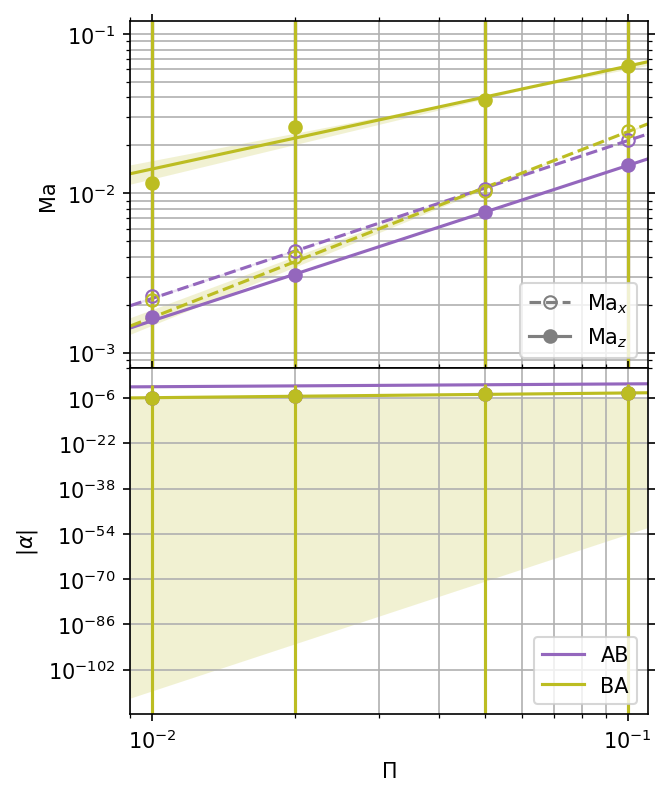

In [ ]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4.45, 6), dpi=150)
workdir = '../unstrat'
cases = [['AB', 'tab:purple',  5], # [case, line style, t_sat]
         ['BA', 'tab:olive', 150]]
Pis = [0.01, 0.02, 0.05, 0.1]
res = '2048'
dirs = [['x', 'dux',   'dux2', 1, 'dashed', 'none'],
        ['z', '2-mom', '2-KE', 2, 'solid' , 'full']]
avgMas = np.zeros((len(Pis), len(dirs)))
stdMas = np.zeros((len(Pis), len(dirs)))
avg_alphas = np.zeros(len(Pis))
std_alphas = np.zeros(len(Pis))
pow_law = lambda x, a, k : a*x**k
xs = np.linspace(9e-3, 1.1e-1)
Ma_runs, tdirs = [], []
Ma_as, Ma_a_errs = [], []
Ma_ks, Ma_k_errs = [], []
Alpha_cases = []
Alpha_as, Alpha_a_errs = [], []
Alpha_ks, Alpha_k_errs = [], []

for i, case in enumerate(cases):
    print(f'{case[0]:s}/0.05')
    for j, dir in enumerate(dirs):
        for k, Pi in enumerate(Pis):
            path = f'{workdir}/{case[0]}/{Pi:0.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            hst = athena_read.hst(f'{path}/output/SI.hst')
            c_s = athinput['hydro']['iso_sound_speed']
            i_sat = int(case[2]/athinput['output3']['dt'])
            Mg = hst['mass']

            # Compute turbulent Mach numbers
            dispersions = np.sqrt(dir[3]*hst[dir[2]]/Mg - (hst[dir[1]]/Mg)**2)
            Mas = dispersions/c_s
            Ma_sat = Mas[i_sat:]
            avgMas[k, j] = np.average(Ma_sat)
            logMa_sat = np.log(Ma_sat)
            std_logMa_sat = np.std(logMa_sat)
            stdMas[k, j] = np.exp(std_logMa_sat)
            if Pi == 0.05:
                print(f'\tMa_{dir[0]} = {avgMas[k, j]:.1e} ± {stdMas[k, j]:.0e}')

            # Compute Reynolds stress and turbulent alpha
            if dir[0] == 'z':
                dux = hst['dux']/Mg
                duy = hst['duy']/Mg
                duxduy = hst['duxduy']/Mg
                if Pi == 0.05: # Diagnostics
                    print(f'\n\tδu_xδu_y = {duxduy[i_sat]:.1e}')
                    print(f'\tδu_x = {dux[i_sat]:.1e}')
                    print(f'\tδu_y = {duy[i_sat]:.1e}')
                    print(f'\tδu_y*δu_x = {duy[i_sat]*dux[i_sat]:.1e}')
                Wxy = (duxduy - duy*dux)
                W_sat = Wxy[i_sat:]
                avg_alphas[k] = np.average(W_sat)/c_s**2
                logW_sat = np.log(W_sat)
                std_logW_sat = np.std(logW_sat)
                std_alphas[k] = np.exp(std_logW_sat)/c_s**2

        # Fit and plot turbulent Mach numbers
        popt, pcov = curve_fit(pow_law, Pis, avgMas[:, j], sigma=stdMas[:, j])
        perr = np.sqrt(np.diag(pcov))
        a, a_err, k, k_err = popt[0], perr[0], popt[1], perr[1]
        fit_low = pow_law(xs, a/a_err, k/k_err)
        fit_high = pow_law(xs, a*a_err, k*k_err)
        axs[0].errorbar(Pis, avgMas[:, j], 2*stdMas[:, j], fmt='o',
                        color=case[1], fillstyle=dir[5])
        axs[0].plot(xs, pow_law(xs, *popt), ls=dir[4], color=case[1])
        axs[0].fill_between(xs, fit_low, fit_high, color=case[1], ec=None,
                        alpha=0.2)
        Ma_runs.append(case[0]); tdirs.append(dir[0])
        Ma_as.append(a); Ma_a_errs.append(a_err)
        Ma_ks.append(k); Ma_k_errs.append(k_err)

    # Fit and plot turbulent alpha
    popt, pcov = curve_fit(pow_law, Pis, avg_alphas,
                           sigma=std_alphas)
    perr = np.sqrt(np.diag(pcov))
    a, a_err, k, k_err = popt[0], perr[0], popt[1], perr[1]
    fit_low = pow_law(xs, a/a_err, k/k_err)
    fit_high = pow_law(xs, a*a_err, k*k_err)
    axs[1].errorbar(Pis, np.abs(avg_alphas), 2*std_alphas, fmt='o',
                    color=case[1])
    axs[1].plot(xs, np.abs(pow_law(xs, *popt)), color=case[1])
    axs[1].fill_between(xs, fit_low, fit_high, color=case[1], ec=None,
                        alpha=0.2)
    Alpha_cases.append(case[0])
    Alpha_as.append(a); Alpha_a_errs.append(a_err)
    Alpha_ks.append(k); Alpha_k_errs.append(k_err)

# Plot line style ghost points; format plots and legend
axs[0].plot([], [], color='tab:gray', ls='--', label='Ma$_x$', fillstyle='none',
        marker='o')
axs[0].plot([], [], color='tab:gray', label='Ma$_z$', marker='o')
axs[0].set(ylabel='Ma', ylim=(8e-4, 1.2e-1), yscale='log')
axs[1].plot([], [], color='tab:purple', label='AB')
axs[1].plot([], [], color='tab:olive', label='BA')
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$|\alpha|$', xlim=(9e-3, 1.1e-1))

for ax in axs.flat:
    ax.grid(which='both')
    ax.legend(loc='lower right')
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(which='both', top=True, right=True)

plt.subplots_adjust(hspace=0)
plt.savefig('figs/machs.pdf', bbox_inches='tight', pad_inches=0.01)

df1 = pd.DataFrame({
    'Case' : Ma_runs,
    'Dir'  : tdirs,
    'a'    : Ma_as,
    '±σ_a' : Ma_a_errs,
    'k'    : Ma_ks,
    '±σ_k' : Ma_k_errs,})
s1 = df1.style.format({
    'a'    : '{:.4f}',
    '±σ_a' : '({:.0e})',
    'k'    : '{:.2e}',
    '±σ_k' : '({:.0e})',})
s1

df2 = pd.DataFrame({
    'Case' : Alpha_cases,
    'a'    : Alpha_as,
    '±σ_a' : Alpha_a_errs,
    'k'    : Alpha_ks,
    '±σ_k' : Alpha_k_errs,})
s2 = df2.style.format({
    'a'    : '{:.2e}',
    '±σ_a' : '({:.0e})',
    'k'    : '{:.2e}',
    '±σ_k' : '({:.0e})',})
s2

## Reynolds stress
Ignoring the Maxwell (magnetic) stress tensor for purely hydrodynamic (unmagnetized) disks, the outward component of the angular momentum flux (turbulent transport) is the dominant $r\phi$ component (in cylindrical coordinates) of the Reynolds (velocity) stress tensor [(Baulbus & Hawley, 1998, Eq. 37)](https://doi.org/10.1103/RevModPhys.70.1)
\begin{equation}
    W_{r\phi} \equiv \langle u_ru_\phi\rangle_\rho,
    \tag{37*}
\end{equation}
where
\begin{equation}
    \langle u_ru_\phi\rangle_\rho = \frac{1}{2\pi\Sigma\Delta r}\int u_ru_\phi\rho\,\mathrm{d}\phi\,\mathrm{d}r\,\mathrm{d}z,
    \tag{36*}
\end{equation}
and the surface density $\Sigma = \int_{-\infty}^\infty\rho_\mathrm{g}\,\mathrm{d}z$.
The *fluctuation velocity* $\mathbf{u}$ is the difference between the fluid velocity $\mathbf{v}$ and the azimuthal circular velocity $r\Omega$, where
\begin{equation}
    u_r = v_r,\quad u_\phi = v_\phi-r\Omega,\quad u_z = v_z.
    \tag{31}
\end{equation}

For our AB and BA simulations, the homogeneous fluid (gas) density is initially unity, i.e., $\rho_\mathrm{g}=1$.

However, the above definitions from [Baulbus & Hawley (1998)](https://doi.org/10.1103/RevModPhys.70.1) are not specific enough for our scenario during the saturated state which includes dust feedback to the gas and a radial pressure gradient.
Thus, we must calculate deviations from the [Nakagawa-Sekiya-Hayashi (1986)](https://ui.adsabs.harvard.edu/abs/1986Icar...67..375N/abstract) equlibrium state as follows:
\begin{align*}
    W_{r\phi} &\equiv \langle\rho_\mathrm{g}\delta u_r\delta u_\phi\rangle \\
    &= \langle\rho_\mathrm{g}(u_r - \overline{u_r})(u_\phi - \overline{u_\phi})\rangle \\
    &= \langle\rho_\mathrm{g} u_ru_\phi\rangle - \langle\rho_\mathrm{g} u_r\overline{u_\phi}\rangle - \langle\rho_\mathrm{g}\overline{u_r}u_\phi\rangle + \langle\overline{u_r}\rho_\mathrm{g}\overline{u_\phi}\rangle \\
    &= \langle\rho_\mathrm{g} u_r^\prime u_\phi^\prime\rangle - \overline{u_\phi}\langle\rho_\mathrm{g} u_r\rangle - \overline{u_r}\langle\rho_\mathrm{g} u_\phi\rangle + \overline{u_r}(\overline{u_\phi}),
\end{align*}
where, in the last term of the last line, we used the fact that $\langle\rho_\mathrm{g}\rangle = \overline{\rho_\mathrm{g}} = 1$, and where the $n$-th moment
\begin{equation}
    \langle g(x, y, z, t)^n \rangle \equiv \frac{1}{M_\mathrm{g}}\int\int\int g(x, y, z, t)^n\rho_\mathrm{g}(x, y, z, t) \mathrm{d}x\mathrm{d}y\mathrm{d}z
\end{equation}
is the volume average of a time-varying gas quantity $g$ over the computational domain, $M_\mathrm{g}$ is the total mass of the gas, $\rho_\mathrm{g}(x, y, z, t)$ is the local gas density at time $t$, and the discretised averages are
\begin{align*}
    \overline{u_{r,\phi}} &= \frac{\sum\rho_\mathrm{g} u_{r,\phi}}{\sum\rho_\mathrm{g}}, \\
    \overline{u_r}(\overline{u_\phi}) &= \frac{\sum\rho_\mathrm{g} u_r\left(\sum\rho_\mathrm{g} u_\phi\right)}{\left(\sum\rho_\mathrm{g}\right)^2}.
\end{align*}


### Athena++ `SI.hst` Outputs
- [Wiki](https://github.com/PrincetonUniversity/athena/wiki/Outputs#history-file): `1-mom`, etc. are global sums, i.e., total momenta in each direction.
  - `scr/outputs/history.cpp`, 141–150:
    ```cpp
    // Hydro conserved variables:
    Real& u_d  = phyd->u(IDN,k,j,i);
    Real& u_mx = phyd->u(IM1,k,j,i);
    Real& u_my = phyd->u(IM2,k,j,i);
    Real& u_mz = phyd->u(IM3,k,j,i);

    hst_data[0] += vol(i)*u_d;
    hst_data[1] += vol(i)*u_mx;
    hst_data[2] += vol(i)*u_my;
    hst_data[3] += vol(i)*u_mz;
    ```
  - $\overline{u_r} = $`1-mom`$/M_\mathrm{g}$
  - $\overline{u_\phi} = $`3-mom`$/M_\mathrm{g}$
  - $\overline{u_z} = $`2-mom`$/M_\mathrm{g}$
- Reuse the history file's existing `dux` and `duy` columns from the `Dux()` and `Duy()` problem generator (pgen) functions.
  - `src/pgen/streaming_instability.cpp`, lines 95-121:
    ```cpp
    //======================================================================================
    //! \fn Real Dux(MeshBlock *pmb, int iout)
    //  \brief Finds the first moment of the radial velocity deviation of the gas.
    //======================================================================================
    Real Dux(MeshBlock *pmb, int iout)
    {
        ...
              integral += rho(k,j,i) * (ux(k,j,i) - ux0) * pcoord->GetCellVolume(k,j,i);
        
        // Return the moment.
        return integral;
    }
    ```
  - $\langle \rho_\mathrm{g}u_r\rangle = $`dux`$/V_\mathrm{tot}$
  - [x] Check if `ux0` and `uy0` equal first line under `1-mom` and `3-mom`, respectively
    ``` cpp
    // Find the Nakagawa-Sekiya-Hayashi (1986) equilibrium solution.
    Real taus(omega * DustParticles::GetStoppingTime());
    Real v(duy0 / (std::pow(1.0 + epsilon, 2) + std::pow(taus, 2)));
    ux0 = 2.0 * epsilon * taus * v;
    uy0 = -((1.0 + epsilon) + std::pow(taus, 2)) * v;
    ```
- Add and enroll `DuxDuy()` to the pgen for a new `duxduy` history column.
  - `src/pgen/streaming_instability.cpp`, lines 211-242:  
    ```cpp
    //======================================================================================
    //! \fn Real DuxDuy(MeshBlock *pmb, int iout)
    //  \brief Finds the product of the first moments of the radial and azimuthal velocity
    //         deviations of the gas.
    //======================================================================================
    Real DuxDuy(MeshBlock *pmb, int iout)
    {
            ...
            Real dux(ux(k,j,i) - ux0);
            Real duy(uy(k,j,i) - uy0);
            integral += rho(k,j,i) * (dux * duy) * pcoord->GetCellVolume(k,j,i);
          }

    // Return the product of the moments.
    return integral;
    }
    ```
  - $\langle\rho_\mathrm{g} u_ru_\phi\rangle = $`duxduy`$/V_\mathrm{tot}$
- (Old)
    - [ ] Given $\rho_\mathrm{g}=1$, does $\Sigma=1$?
      

### $\alpha$ parameter
From [Baulbus & Hawley (1998)](https://doi.org/10.1103/RevModPhys.70.1), Eq. 48,
\begin{equation*}
    W_{r\phi} = \alpha c_\mathrm{s}^2
\end{equation*}
where $c_\mathrm{s}$ is the sound speed.